In [1]:
!date

Fri May 22 16:14:14 JST 2020


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results/Andrei/Stan-sims

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [3]:
resultsdir = "../../../../Hokkaido_Backup_old/Wuhan_Serial_interval_2020/certain"
dirs = !ls "{resultsdir}"
dirs

['gamma-no_truncation',
 'gamma-truncated',
 'lognormal-no_truncation',
 'lognormal-truncated',
 'weibull-no_truncation',
 'weibull-truncated']

In [4]:
distribs = np.unique([folder.split("/")[-1].split("-")[0] for folder in dirs])
distribs

array(['gamma', 'lognormal', 'weibull'], dtype='<U9')

In [5]:
truncations = np.unique([folder.split("/")[-1].split("-")[1] for folder in dirs])
truncations

array(['no_truncation', 'truncated'], dtype='<U13')

In [6]:
traceplotsdir = "../../results/Andrei/Stan-sims/traceplots-certain"
!mkdir -p {traceplotsdir}
tracesdir = "../../results/Andrei/Stan-sims/traces-certain"
!mkdir -p {tracesdir}

# No truncation

lognormal-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.346,0.665,3.130,5.666,0.002,0.002,91618.0,81594.0,105991.0,64029.0,1.0
sd_SI,3.026,0.965,1.631,4.914,0.004,0.003,70979.0,59145.0,102493.0,59004.0,1.0
param1,1.261,0.149,0.971,1.558,0.000,0.000,113802.0,113802.0,114935.0,84043.0,1.0
param2,0.618,0.108,0.430,0.838,0.000,0.000,92443.0,84991.0,104268.0,75618.0,1.0


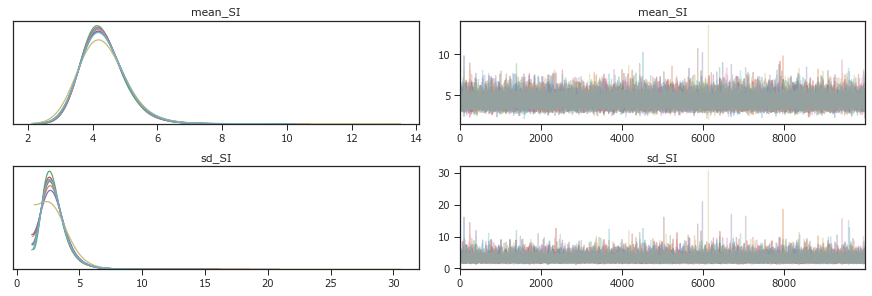

In [7]:
folder = "lognormal-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['s_raw','e_raw','logmean_SI','logsd_SI','s','e']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[ 1.         -0.24420051]
 [-0.24420051  1.        ]]
Covariance matrix
[[ 0.02219721 -0.00392998]
 [-0.00392998  0.0116678 ]]
Precision matrix
[[47.90763202 16.13637455]
 [16.13637455 91.1410654 ]]


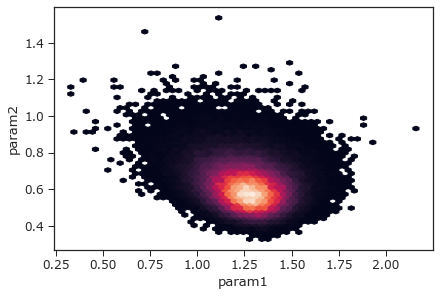

In [8]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

gamma-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.614,0.710,3.313,6.020,0.003,0.002,76042.0,67442.0,88547.0,60920.0,1.0
sd_SI,2.896,0.771,1.672,4.387,0.003,0.002,61861.0,51206.0,82675.0,59107.0,1.0
param1,2.815,1.009,1.068,4.840,0.003,0.002,111371.0,111371.0,101289.0,72640.0,1.0
param2,0.625,0.243,0.201,1.110,0.001,0.001,98343.0,98343.0,86729.0,65538.0,1.0


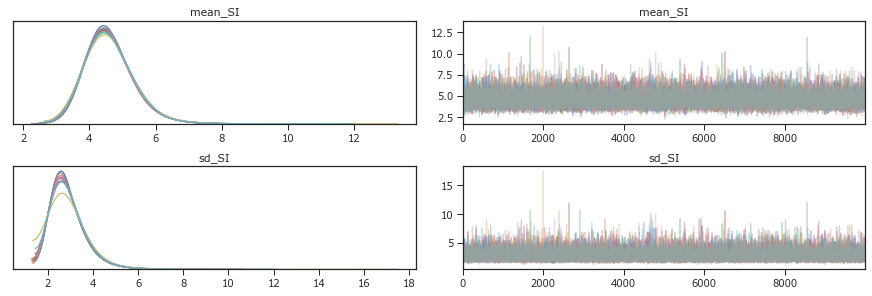

In [9]:
folder = "gamma-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names = ['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names = ['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.93370063]
 [0.93370063 1.        ]]
Covariance matrix
[[1.01791992 0.22908776]
 [0.22908776 0.05913912]]
Precision matrix
[[  7.66280453 -29.68347738]
 [-29.68347738 131.89444425]]


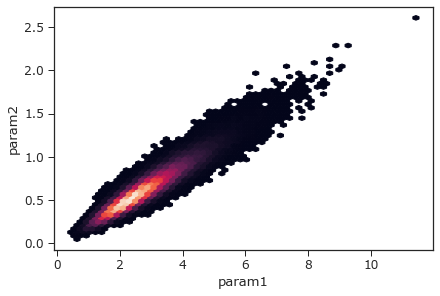

In [10]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

weibull-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.548,0.606,3.386,5.730,0.002,0.001,91883.0,83968.0,100061.0,65475.0,1.0
sd_SI,2.516,0.580,1.663,3.642,0.002,0.002,65331.0,50060.0,110434.0,56751.0,1.0
param1,1.946,0.376,1.230,2.694,0.001,0.001,96816.0,96816.0,93389.0,65674.0,1.0
param2,5.096,0.679,3.795,6.447,0.002,0.002,97741.0,92795.0,101535.0,69454.0,1.0


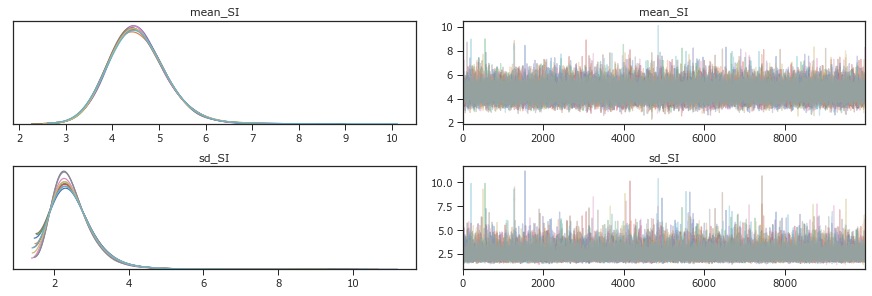

In [11]:
folder = "weibull-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.20727938]
 [0.20727938 1.        ]]
Covariance matrix
[[0.14125938 0.05289638]
 [0.05289638 0.4610228 ]]
Precision matrix
[[ 7.39698558 -0.84870804]
 [-0.84870804  2.26646833]]


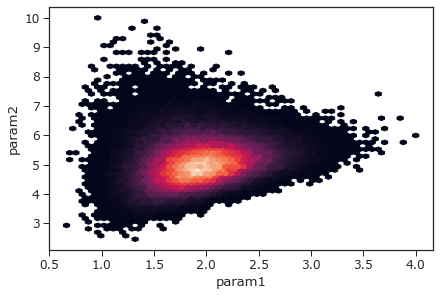

In [12]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

## Comparing different models

In [13]:
for truncation_type in ['no_truncation']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))
        posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
        cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                                       log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        df_params12 = pd.DataFrame({'param1': param1, 'param2': param2})
        df_params12.to_pickle(tracesdir+'/'+folder+'.pickle')
        df_params12.round(5).to_csv(tracesdir+'/'+folder+'.csv', index=False)
        cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking', ic='waic', scale='deviance')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-certain-'+truncation_type+'.xlsx')

gamma-no_truncation
['gamma', 'no_truncation', '4.6 (3.4, 6.2)', '2.9 (1.8, 4.8)', '1.1 (0.4, 1.9)', '4.0 (2.8, 5.3)', '9.8 (7.3, 15.3)', '13.3 (9.4, 22.1)']
lognormal-no_truncation
['lognormal', 'no_truncation', '4.3 (3.3, 5.9)', '3.0 (1.8, 5.4)', '1.3 (0.7, 1.9)', '3.6 (2.6, 4.7)', '9.6 (6.9, 15.1)', '14.5 (9.7, 26.4)']
weibull-no_truncation
['weibull', 'no_truncation', '4.5 (3.5, 5.9)', '2.5 (1.8, 3.9)', '1.1 (0.4, 1.9)', '4.2 (3.0, 5.4)', '8.9 (7.1, 13.2)', '11.1 (8.5, 17.8)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,weibull,88.8,0.00,0.958,no_truncation,"4.5 (3.5, 5.9)","2.5 (1.8, 3.9)","1.1 (0.4, 1.9)","4.2 (3.0, 5.4)","8.9 (7.1, 13.2)","11.1 (8.5, 17.8)"
1,gamma,89.8,1.08,0.042,no_truncation,"4.6 (3.4, 6.2)","2.9 (1.8, 4.8)","1.1 (0.4, 1.9)","4.0 (2.8, 5.3)","9.8 (7.3, 15.3)","13.3 (9.4, 22.1)"
2,lognormal,91.2,2.44,0.000,no_truncation,"4.3 (3.3, 5.9)","3.0 (1.8, 5.4)","1.3 (0.7, 1.9)","3.6 (2.6, 4.7)","9.6 (6.9, 15.1)","14.5 (9.7, 26.4)"


# With truncation

lognormal-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.474,0.760,3.144,5.980,0.003,0.002,78829.0,66905.0,101484.0,58875.0,1.0
sd_SI,3.242,1.207,1.614,5.535,0.005,0.004,61854.0,48315.0,101246.0,56591.0,1.0
param1,1.277,0.154,0.963,1.569,0.000,0.000,108170.0,107656.0,108920.0,83195.0,1.0
param2,0.635,0.117,0.427,0.869,0.000,0.000,85715.0,77782.0,98548.0,70815.0,1.0


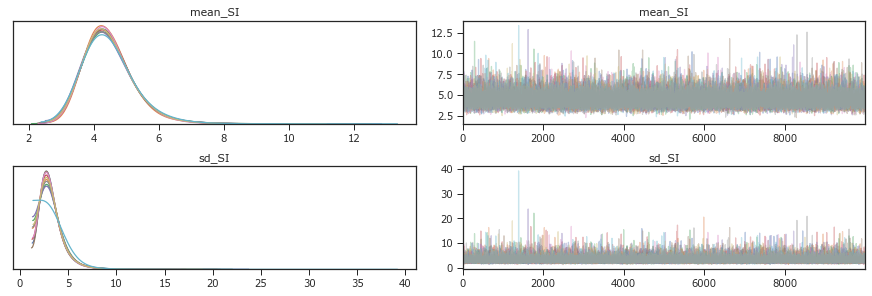

In [14]:
folder = "lognormal-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[ 1.         -0.16097967]
 [-0.16097967  1.        ]]
Covariance matrix
[[ 0.02367249 -0.00290545]
 [-0.00290545  0.01376068]]
Precision matrix
[[43.36696002  9.15655156]
 [ 9.15655156 74.60412657]]


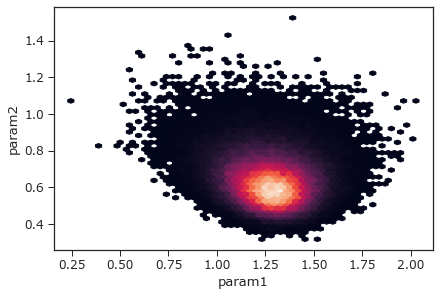

In [15]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

gamma-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.777,0.881,3.297,6.437,0.004,0.003,55098.0,42565.0,88380.0,47808.0,1.0
sd_SI,3.090,1.039,1.663,4.977,0.005,0.004,44937.0,34379.0,83821.0,47052.0,1.0
param1,2.712,1.009,0.973,4.742,0.003,0.002,97121.0,97121.0,86915.0,64948.0,1.0
param2,0.590,0.247,0.158,1.084,0.001,0.001,97145.0,97145.0,81152.0,51744.0,1.0


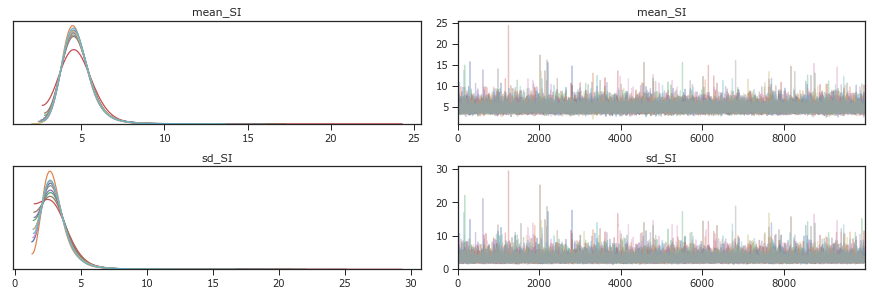

In [16]:
folder = "gamma-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))   

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.93647913]
 [0.93647913 1.        ]]
Covariance matrix
[[1.01892794 0.23365262]
 [0.23365262 0.06109443]]
Precision matrix
[[  7.97861012 -30.51379778]
 [-30.51379778 133.0666064 ]]


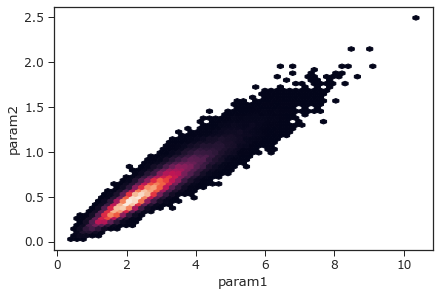

In [17]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

weibull-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.662,0.766,3.411,6.045,0.004,0.003,42567.0,27773.0,82609.0,46580.0,1.0
sd_SI,2.644,0.901,1.630,4.011,0.005,0.004,28327.0,22338.0,82544.0,42355.0,1.0
param1,1.918,0.389,1.159,2.682,0.001,0.001,82768.0,82768.0,79317.0,54345.0,1.0
param2,5.211,0.801,3.772,6.706,0.003,0.003,55603.0,38965.0,86173.0,52102.0,1.0


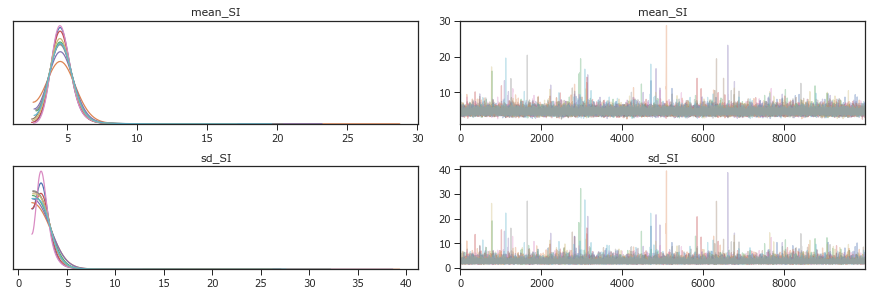

In [18]:
folder = "weibull-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))   

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig(traceplotsdir+"/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

Correlation matrix
[[1.         0.04970976]
 [0.04970976 1.        ]]
Covariance matrix
[[0.15105023 0.01547219]
 [0.01547219 0.64135567]]
Precision matrix
[[ 6.63671391 -0.16010539]
 [-0.16010539  1.56305966]]


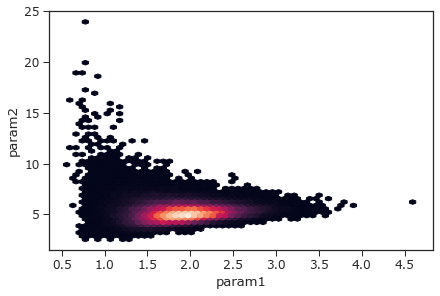

In [19]:
# correlation between param1 and param2
az.plot_pair(cmdstan_data, var_names = ['param1', 'param2'], kind='hexbin');

param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()
print(colored("Correlation matrix","blue"))
print(np.corrcoef(np.array([param1,param2])))
print(colored("Covariance matrix","blue"))
print(np.cov(np.array([param1,param2])))
print(colored("Precision matrix","blue"))
print(np.linalg.inv(np.cov(np.array([param1,param2]))))

In [20]:
for truncation_type in ['truncated']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        
        print(colored(folder, 'red'))
        posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
        cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                                       log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        df_params12 = pd.DataFrame({'param1': param1, 'param2': param2})
        df_params12.to_pickle(tracesdir+'/'+folder+'.pickle')
        df_params12.round(5).to_csv(tracesdir+'/'+folder+'.csv', index=False)
        cmdstan_stats = get_stats(cmdstan_data.posterior.drop(['e_raw','s_raw','e','s']))   

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking', ic='waic', scale='deviance')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-certain-'+truncation_type+'.xlsx')

gamma-truncated
['gamma', 'truncated', '4.8 (3.5, 6.8)', '3.1 (1.9, 5.6)', '1.1 (0.3, 1.9)', '4.1 (2.9, 5.7)', '10.1 (7.4, 17.8)', '13.8 (9.6, 26.5)']
lognormal-truncated
['lognormal', 'truncated', '4.5 (3.3, 6.3)', '3.2 (1.8, 6.3)', '1.3 (0.7, 1.9)', '3.6 (2.6, 4.8)', '10.0 (7.0, 17.2)', '15.2 (9.8, 31.2)']
weibull-truncated
['weibull', 'truncated', '4.7 (3.5, 6.3)', '2.6 (1.8, 4.5)', '1.1 (0.4, 1.9)', '4.2 (3.0, 5.6)', '9.1 (7.1, 14.6)', '11.4 (8.6, 20.2)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,weibull,133.3,0.00,1.0,truncated,"4.7 (3.5, 6.3)","2.6 (1.8, 4.5)","1.1 (0.4, 1.9)","4.2 (3.0, 5.6)","9.1 (7.1, 14.6)","11.4 (8.6, 20.2)"
1,gamma,154.6,21.31,0.0,truncated,"4.8 (3.5, 6.8)","3.1 (1.9, 5.6)","1.1 (0.3, 1.9)","4.1 (2.9, 5.7)","10.1 (7.4, 17.8)","13.8 (9.6, 26.5)"
2,lognormal,155.9,22.57,0.0,truncated,"4.5 (3.3, 6.3)","3.2 (1.8, 6.3)","1.3 (0.7, 1.9)","3.6 (2.6, 4.8)","10.0 (7.0, 17.2)","15.2 (9.8, 31.2)"
